# **CLIPと言語モデルを組み合わせたVLM**
ここでは，CLIPの画像エンコーダと言語モデル (LLM) を組み合わせて，VLM（Vision Language Model）を構築します．<br>
今回はColab上で動作可能であることを考慮して，言語モデルとして比較的軽量なGPT-2を用いて演習を行います．
<br>
<br>
※本演習は実行に約30分程度かかります．（T4 GPU, 2エポック学習時 / 無料版Colabでも実行できます）

## 準備
はじめに，本演習を行うために必要な準備を行います．

### 必要パッケージのインストールとモジュールのインポート

In [ ]:
# 必要パッケージのインストール（2分程度かかります）
!pip install -q git+https://github.com/openai/CLIP.git > /dev/null
!wget -qO example.jpg "https://pbs.twimg.com/profile_images/580249464180342784/4_-Ch2jR_400x400.png"
!pip install -q torchinfo
!pip install -q nltk

In [ ]:
import csv
import json
import math
import os
import random
import types
from pathlib import Path
from typing import Any, Dict, List, Literal, Optional

import clip
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2Tokenizer

---
## **各モデルの確認**
はじめに，CLIPの画像エンコーダとGPT-2のそれぞれのモデルについて理解します．

###  **モデルの確認：CLIPの画像エンコーダ**
CLIPの画像エンコーダについて，モデルの構造や挙動を確認します．

In [ ]:
# CLIPの学習済みモデルとpreprocessの用意
model, preprocess = clip.load('ViT-L/14', "cpu")
image_encoder = model.visual
summary(image_encoder)

100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 85.5MiB/s]


Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 1,050,624
├─Conv2d: 1-1                                                     602,112
├─LayerNorm: 1-2                                                  2,048
├─Transformer: 1-3                                                --
│    └─Sequential: 2-1                                            --
│    │    └─ResidualAttentionBlock: 3-1                           12,596,224
│    │    └─ResidualAttentionBlock: 3-2                           12,596,224
│    │    └─ResidualAttentionBlock: 3-3                           12,596,224
│    │    └─ResidualAttentionBlock: 3-4                           12,596,224
│    │    └─ResidualAttentionBlock: 3-5                           12,596,224
│    │    └─ResidualAttentionBlock: 3-6                           12,596,224
│    │    └─ResidualAttentionBlock: 3-7                           12,596,224
│    │    └─ResidualAttenti

これにより，CLIPの画像エンコーダを取得できました．<br>
中身を確認すると，VisionTransformerモデルになっていることが確認できます．

In [ ]:
sample_image = preprocess(Image.open("example.jpg")).unsqueeze(0)
print("sample_image.shape: ", sample_image.shape)

# CLIPのエンコーダによる処理
output_tokens = image_encoder(sample_image)

print("output_tokens.shape: ", output_tokens.shape) #torch.Size([1, 768]) -> [batch_size, dim]

sample_image.shape:  torch.Size([1, 3, 224, 224])
output_tokens.shape:  torch.Size([1, 768])


以上の結果を確認するとCLIPのVisionEncoder部分の出力は，CLSトークンの1トークンの特徴ベクトルを出力するようになっています．<br>
VLMモデルを構築する時は，CLSトークンのみをLLMに入力するのではなく，すべてのトークンや圧縮した数トークンをLLMに入力することが多いです．<br>

#### **（課題用）CLIPの画像エンコーダの改良**
そこでCLIPの画像エンコーダの`forward()`関数を上書きしてすべてのトークンを出力するようにします．<br>
**※最初の演習では，CLSトークンのみを用いてモデルを作ります．（CLIPのデフォルトのまま使用するのでこの部分はスキップ）**<br>
**※演習後の課題の部分でこの部分（コメントアウト部分）を活用して，課題に取り組んでみてください．**

In [ ]:
# # 1. 上書き用のすべてのトークンを出力するように変更した新たなforward()関数を作成
# def forward_output_all_tokens(self, x: torch.Tensor):
#     x = self.conv1(x)  # shape = [*, width, grid, grid]
#     x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
#     x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
#     x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
#     x = x + self.positional_embedding.to(x.dtype)
#     x = self.ln_pre(x)

#     x = x.permute(1, 0, 2)  # NLD -> LND
#     x = self.transformer(x)
#     x = x.permute(1, 0, 2)  # LND -> NLD

#     x = self.ln_post(x)

#     if self.proj is not None:
#         x = x @ self.proj

#     return x

# # 2. forwardメソッドを上書き
# image_encoder.forward = types.MethodType(forward_output_all_tokens, image_encoder)

# # 3. 上書きされたかのチェック
# sample_image = preprocess(Image.open("example.jpg")).unsqueeze(0)  # [1, 3, H, W]
# output = image_encoder(sample_image)  # [1, grid**2+1, depth]
# print(output.shape)

### **モデルの確認：GPT-2**

In [ ]:
# モデルとトークナイザーの読み込み
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)

summary(gpt2_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Layer (type:depth-idx)                             Param #
GPT2LMHeadModel                                    --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              38,597,376
│    └─Embedding: 2-2                              786,432
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         7,087,872
│    │    └─GPT2Block: 3-2                         7,087,872
│    │    └─GPT2Block: 3-3                         7,087,872
│    │    └─GPT2Block: 3-4                         7,087,872
│    │    └─GPT2Block: 3-5                         7,087,872
│    │    └─GPT2Block: 3-6                         7,087,872
│    │    └─GPT2Block: 3-7                         7,087,872
│    │    └─GPT2Block: 3-8                         7,087,872
│    │    └─GPT2Block: 3-9                         7,087,872
│    │    └─GPT2Block: 3-10                        7,08

In [ ]:
# 入力テキスト
prompt = "What is a language model?"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# テキスト生成
output_ids = gpt2_model.generate(
    input_ids,
    max_length=150,         # 生成するトークン数の上限
    do_sample=True,        # サンプリングを有効化
    top_p=0.9,             # nucleus sampling
    temperature=0.8,       # 多様性制御
    pad_token_id=tokenizer.eos_token_id
)

# デコードして表示
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("=== Generated Text ===")
print(generated_text)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== Generated Text ===
What is a language model? What does it mean? What does it do? What do we call it? Is it just a new language? Does it exist?

It's difficult to explain the language model, since there are so many different languages that one can only guess at. But this is what we have done, and we are going to try to explain it as best we can.

Language models are a series of ideas, some of them simple. It's called a language model. I will say that the language model is the simplest language model of all, because there is no way we can talk about it without breaking things down into simple concepts.

The idea of language models is that language models are ideas, rather


---
## **画像キャプション データセット**
**画像キャプションタスク**とは，入力された画像の内容を自然言語の文章で説明するタスクのことです．<br>
英語では Image Captioning と呼ばれ，コンピュータビジョン（CV）と自然言語処理（NLP）の両方の技術を組み合わせた典型的なマルチモーダルなタスクです．

### COCO データセット
COCOデータセット（MS COCO: Microsoft Common Objects in Context）は，
コンピュータビジョン分野で非常によく使われる大規模な画像データセットで，複数のタスクに利用されいています．<br>


| タスク                                         | 説明                | アノテーション形式         |
| ------------------------------------------- | ----------------- | ----------------- |
| **物体検出 (Object Detection)**                 | 画像中の物体の位置とカテゴリを予測 | バウンディングボックス + ラベル |
| **インスタンスセグメンテーション (Instance Segmentation)** | 物体ごとのピクセル単位の領域を予測 | マスク + ラベル         |
| **キーポイント検出 (Keypoint Detection)**           | 人物の関節位置などを予測      | 17個の人体キーポイント      |
| **キャプション生成 (Image Captioning)**             | 画像を説明する自然文を生成     | 画像ごとに5つのキャプション    |




In [ ]:
# データセットのダウンロード（1分程度かかります）
!wget -q -O val2017.zip http://images.cocodataset.org/zips/val2017.zip
!wget -q -O annotations_trainval2017.zip http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

上記のダウンロード・解凍により，<br>
`/val2017`に画像データ，`/captions_val2017.json`に検証用データに対応したアノテーションデータが格納されたデータを用意できました．<br>
<br>
**⚠️注意**<br>
今回の学習では，リソースの関係で小規模なデータセットで学習を行います．<br>
具体的には，公開されているCOCOデータセットの内，検証用データとして公開されているデータを今回学習に使用する学習用データと検証用データに分割して利用します．
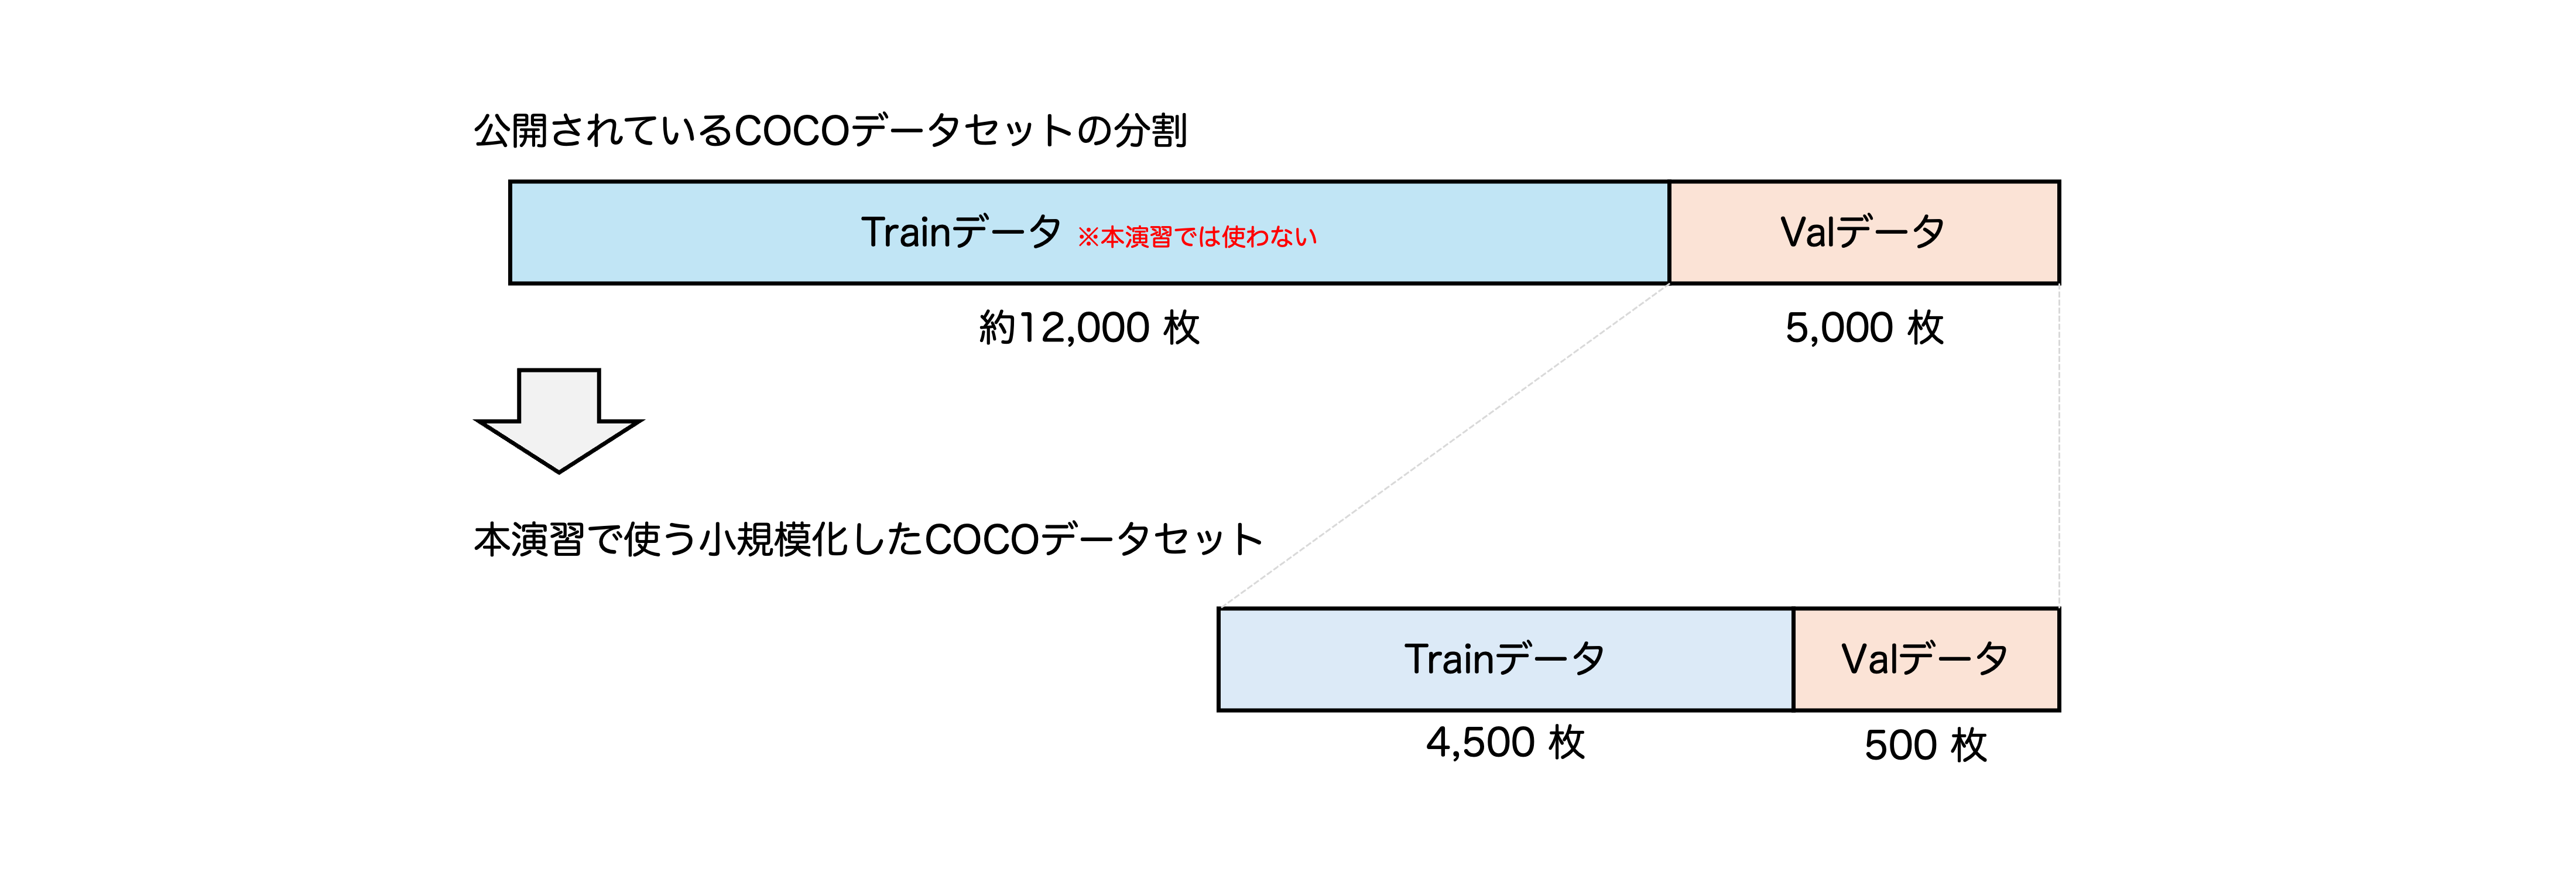

以下のプログラムで小規模化したCOCOデータセットを作成します

In [ ]:
ANNOT_PATH = "annotations/captions_val2017.json"
IMG_DIR    = "val2017"

random_seed = 42
# どちらかを使う：1) 枚数指定  2) 比率指定（枚数指定が優先されます）
n_train = None   # 例: 1000枚
n_val   = None    # 例: 200枚
train_ratio = 0.9  # 枚数未指定(None)のときだけ使用


random.seed(random_seed)
with open(ANNOT_PATH, "r") as f:
    coco = json.load(f)

# 画像ID -> file_name
id2file = {img["id"]: img["file_name"] for img in coco["images"]}

# 画像ID -> [captions...]
caps = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    if img_id in id2file:
        caps.setdefault(img_id, []).append(ann["caption"])

valid_img_ids = []
for img_id, file_name in id2file.items():
    if (Path(IMG_DIR) / file_name).exists() and img_id in caps:
        valid_img_ids.append(img_id)

random.shuffle(valid_img_ids)

if n_train is None or n_val is None:
    split_idx = int(len(valid_img_ids) * train_ratio)
    train_ids = set(valid_img_ids[:split_idx])
    val_ids   = set(valid_img_ids[split_idx:])
else:
    need = n_train + n_val
    pool = valid_img_ids if len(valid_img_ids) >= need else valid_img_ids
    train_ids = set(pool[:n_train])
    val_ids   = set(pool[n_train:n_train+n_val])

def make_pairs(selected_ids):
    out = []
    for img_id in selected_ids:
        file_name = id2file[img_id]
        out.append({
            "image": f"{IMG_DIR}/{file_name}",
            "captions": caps.get(img_id, [])
        })
    return out

train_pairs = make_pairs(sorted(train_ids))
val_pairs   = make_pairs(sorted(val_ids))

with open("train_small.json", "w", encoding="utf-8") as f:
    json.dump(train_pairs, f, ensure_ascii=False, indent=2)
with open("val_small.json", "w", encoding="utf-8") as f:
    json.dump(val_pairs, f, ensure_ascii=False, indent=2)

print("Done.")
print(f"train images: {len(train_pairs)}")
print(f"val images:   {len(val_pairs)}")


Done.
train images: 4500
val images:   500


上記のプログラムで，公開されているCOCOデータセットの検証用データを分割して，小規模化した学習用データ`train_small.json`と検証用データ`val_small.json`を構築できました．<br>
最後に構築したデータのそれぞれの画像枚数を表示しています．

---
### **データセット・データローダーの定義**
COCOを扱うDatasetを定義します．<br>
この時，学習時と評価時で異なる使い方を行うため，`Mode`により使い方を制御するようにしています．<br>
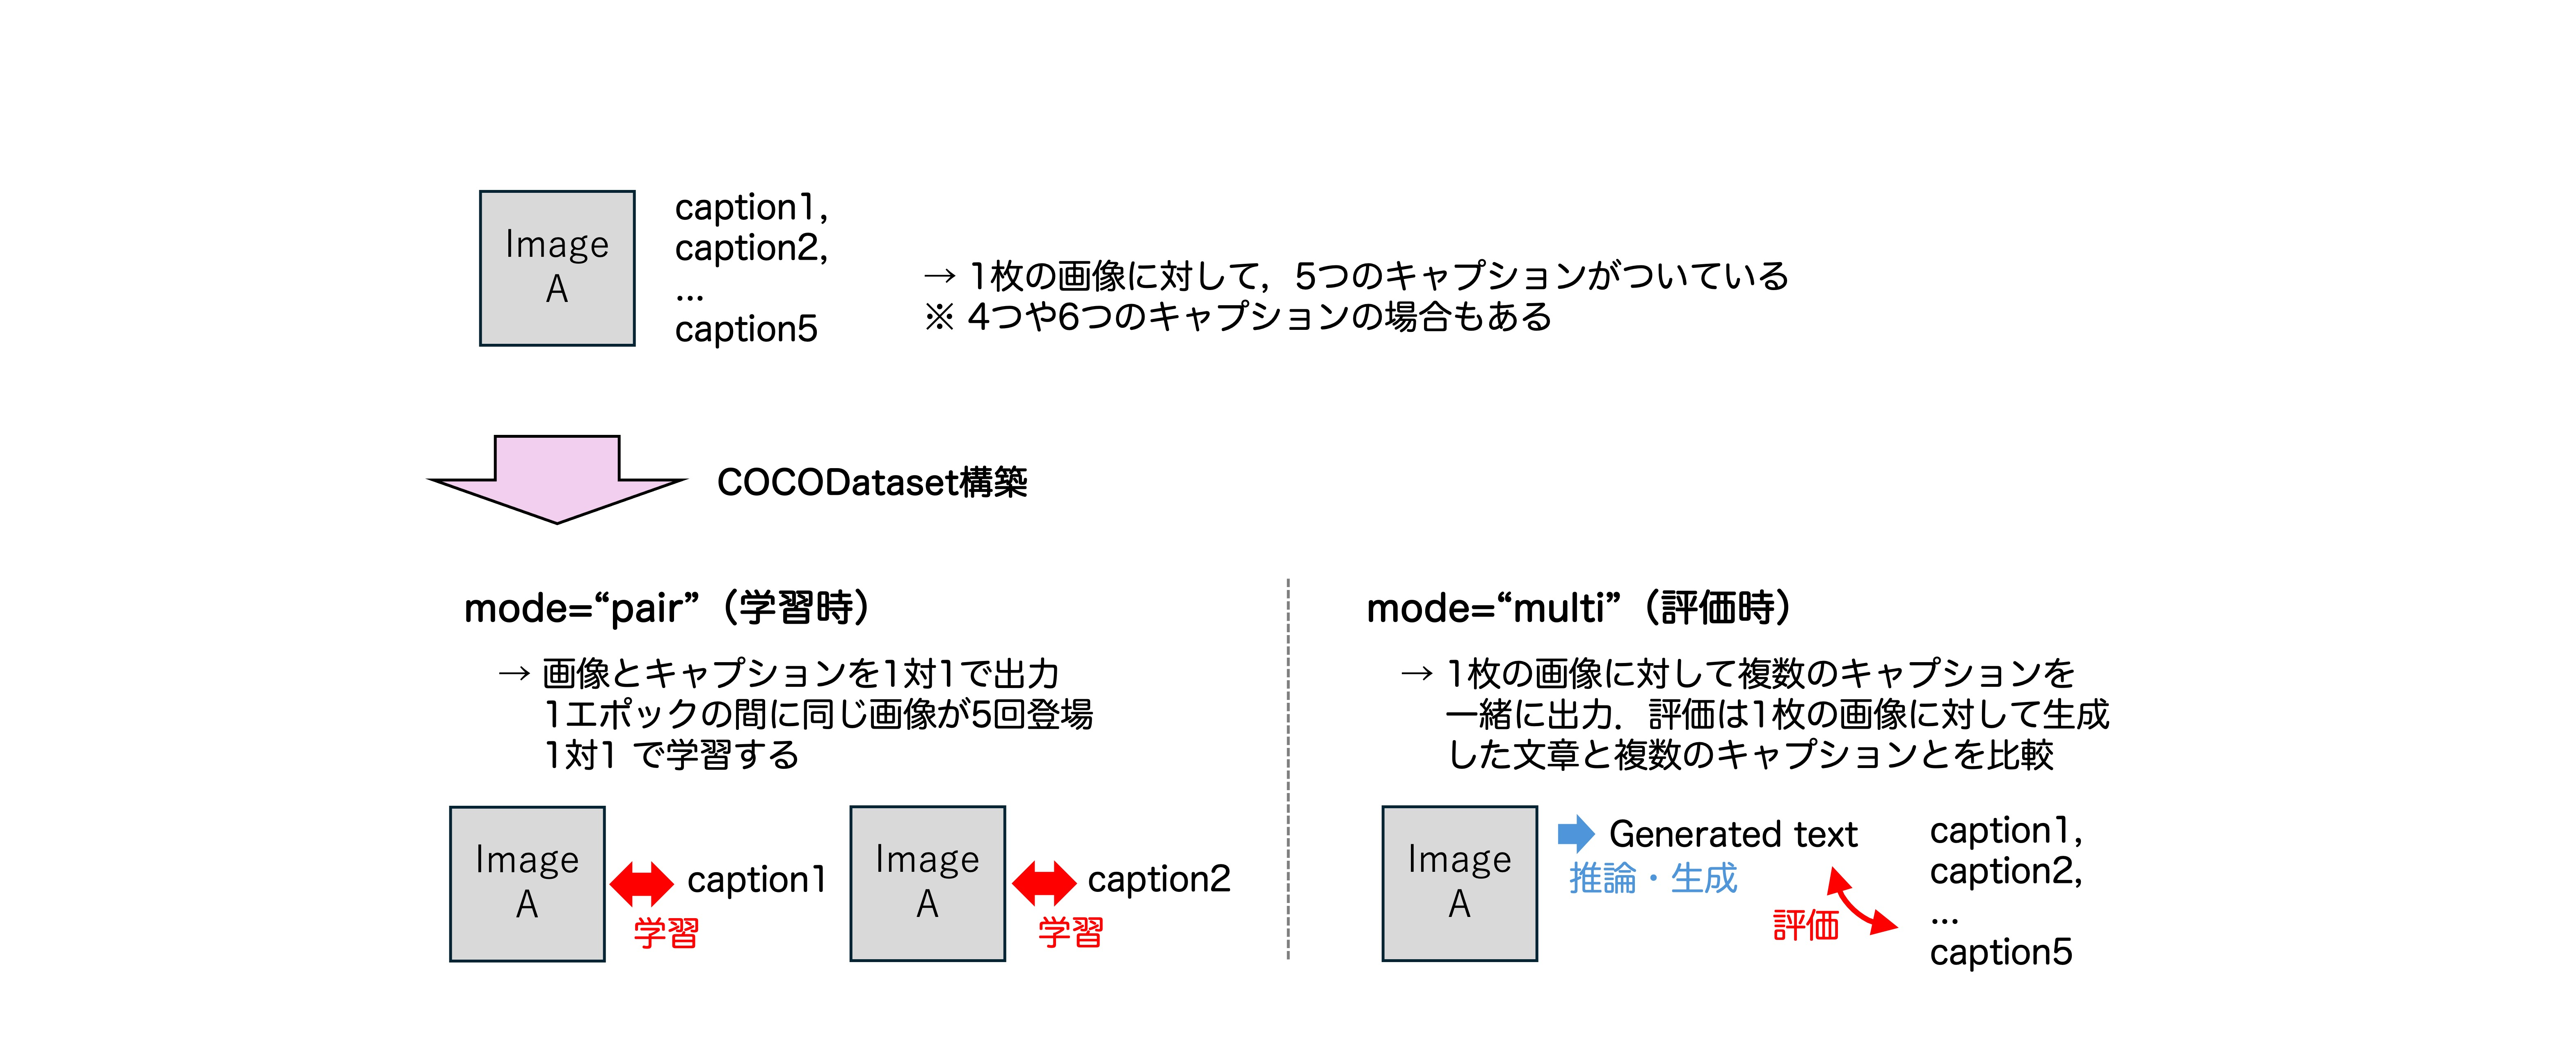

In [ ]:
Mode = Literal["pair", "multi"]

class COCODataset(Dataset):
    """
    JSON: [{"image": "val2017/000000123456.jpg", "captions": ["...", "...", ...]}, ...]
    mode="pair"  : 画像-単一キャプションに分解し、tokenize した input_ids/attention_mask を返す
    mode="multi" : 画像-複数キャプション（文字列リスト）をそのまま返す（BLEU参照用）
    """
    def __init__(
        self,
        json_path: str,
        mode: Mode = "pair",
        clip_preprocess=None,            # clip.load(...)[1] を渡す（推奨）
        tokenizer=None,                  # GPT2など（pairで使用）
        max_length: int = 64,
        return_path: bool = False,
        transform=None                   # clip_preprocess が無いとき用のフォールバック
    ):
        assert mode in ("pair", "multi")
        self.mode: Mode = mode
        self.clip_preprocess = clip_preprocess
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.return_path = return_path
        self.transform = transform

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 空文字等のキャプションを除去
        cleaned = []
        for item in data:
            caps = [str(c).strip() for c in item.get("captions", []) if str(c).strip()]
            if not caps:
                continue
            cleaned.append({"image": item["image"], "captions": caps})

        self._build_index(cleaned)

    def _build_index(self, data: List[Dict[str, Any]]):
        self.items_multi = data
        if self.mode == "pair":
            self.items_pair = []
            for d in data:
                img_path = d["image"]
                for cap in d["captions"]:
                    self.items_pair.append({"image": img_path, "caption": cap})

        # 画像ID（ファイル名の数値）を推定（必要なら使う）
        def infer_image_id(p: str) -> Optional[int]:
            try:
                return int(Path(p).stem)
            except Exception:
                return None

        self.image_ids_multi = [infer_image_id(d["image"]) for d in self.items_multi]
        if self.mode == "pair":
            self.image_ids_pair = [infer_image_id(d["image"]) for d in self.items_pair]

    def __len__(self):
        return len(self.items_pair) if self.mode == "pair" else len(self.items_multi)

    def _load_pil(self, path: str):
        # JSONは相対パス想定（例: val2017/xxxx.jpg）
        return Image.open(path).convert("RGB")

    def _to_pixel_values(self, pil_img: Image.Image):
        if self.clip_preprocess is not None:
            # CLIPの前処理（CHW Tensor）
            return self.clip_preprocess(pil_img)
        if self.transform is not None:
            return self.transform(pil_img)
        # 何も無い場合はPILのまま返す（collateで扱うなら注意）
        return pil_img

    def __getitem__(self, idx: int):
        if self.mode == "pair":
            item = self.items_pair[idx]
            pil = self._load_pil(item["image"])
            pixel_values = self._to_pixel_values(pil)

            out = {"pixel_values": pixel_values,
                   "caption": item["caption"],
                   }
            if self.tokenizer is not None:
                toks = self.tokenizer(
                    item["caption"],
                    max_length=self.max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt",
                )
                out["input_ids"] = toks["input_ids"].squeeze(0)
                out["attention_mask"] = toks["attention_mask"].squeeze(0)
            if self.return_path:
                out["image_path"] = item["image"]
            return out

        else:  # mode == "multi"
            item = self.items_multi[idx]
            pil = self._load_pil(item["image"])
            pixel_values = self._to_pixel_values(pil)
            out = {
                "pixel_values": pixel_values,   # BLEU時に画像も扱いたい場合用
                "captions": item["captions"],   # 参照文（文字列リスト）
            }
            if self.return_path:
                out["image_path"] = item["image"]
            return out

In [ ]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = COCODataset(
    "train_small.json",
    mode="pair",
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=False,
)

val_ds = COCODataset(
    "val_small.json",
    mode="pair",
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=True,
)

print("len(train_ds)", len(train_ds))
print("len(val_ds) : ", len(val_ds))

len(train_ds) 22513
len(val_ds) :  2501


### **データセットの可視化**

In [ ]:
# データセットのサンプルを可視化する関数
def show_sample(dataset, idx: int):
    """
    指定したインデックスのサンプルを可視化。
    mode="pair" の場合: 単一キャプション
    mode="multi" の場合: 複数キャプションを改行で表示
    """
    sample = dataset[idx]
    img_path = sample["image_path"]
    image = Image.open(img_path).convert("RGB")

    # キャプション取得
    if dataset.mode == "pair":
        caption_text = sample["caption"]
    else:
        caption_text = "\n".join(sample["captions"])

    # 表示
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption_text, fontsize=10)
    plt.show()

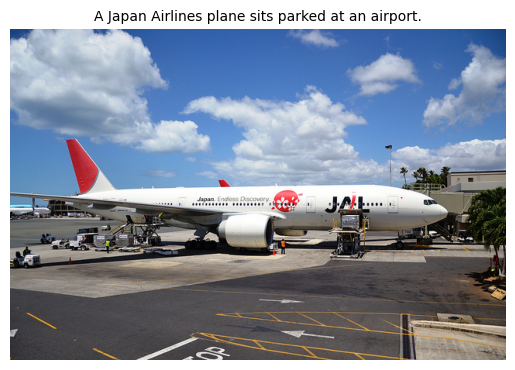

In [ ]:
index = 44
show_sample(val_ds, index)

### **データローダーの構築**

In [ ]:
def collate_pair(batch):
    pixels = torch.stack([b["pixel_values"] for b in batch], dim=0)
    out = {"pixel_values": pixels, "captions": [b["caption"] for b in batch]}

    if ("input_ids" in batch[0]) and ("attention_mask" in batch[0]):
        out["input_ids"] = torch.stack([b["input_ids"] for b in batch], dim=0)
        out["attention_mask"] = torch.stack([b["attention_mask"] for b in batch], dim=0)
        labels = out["input_ids"].clone()
        labels[out["attention_mask"] == 0] = -100
        out["labels"] = labels
    return out

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_pair)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pair)

 ---
 ## **モデルの構築**
シンプルなVLMモデルを構築します．<br>
CLIPの画像エンコーダを用いてエンコードした画像特徴（CLSトークン）をプロンプトの埋め込みと結合してLLM（本ノートブックではGPT-2）に入力します．LLMは画像特徴とプロンプトの情報から自己回帰的に次の単語を予測します．<br>
CLIPは画像と言語で対象学習されているため，CLIPの画像エンコーダは言語とのアライメントが取れた画像特徴を抽出できます．<br>
しかし，LLMの言語特徴空間とはアライメントは取れていない状態です．そのため，`adapter`と呼ばれる射影層を間にいれることで，CLIPの特徴空間をLLMの特徴空間に合わせるように射影します．<br>
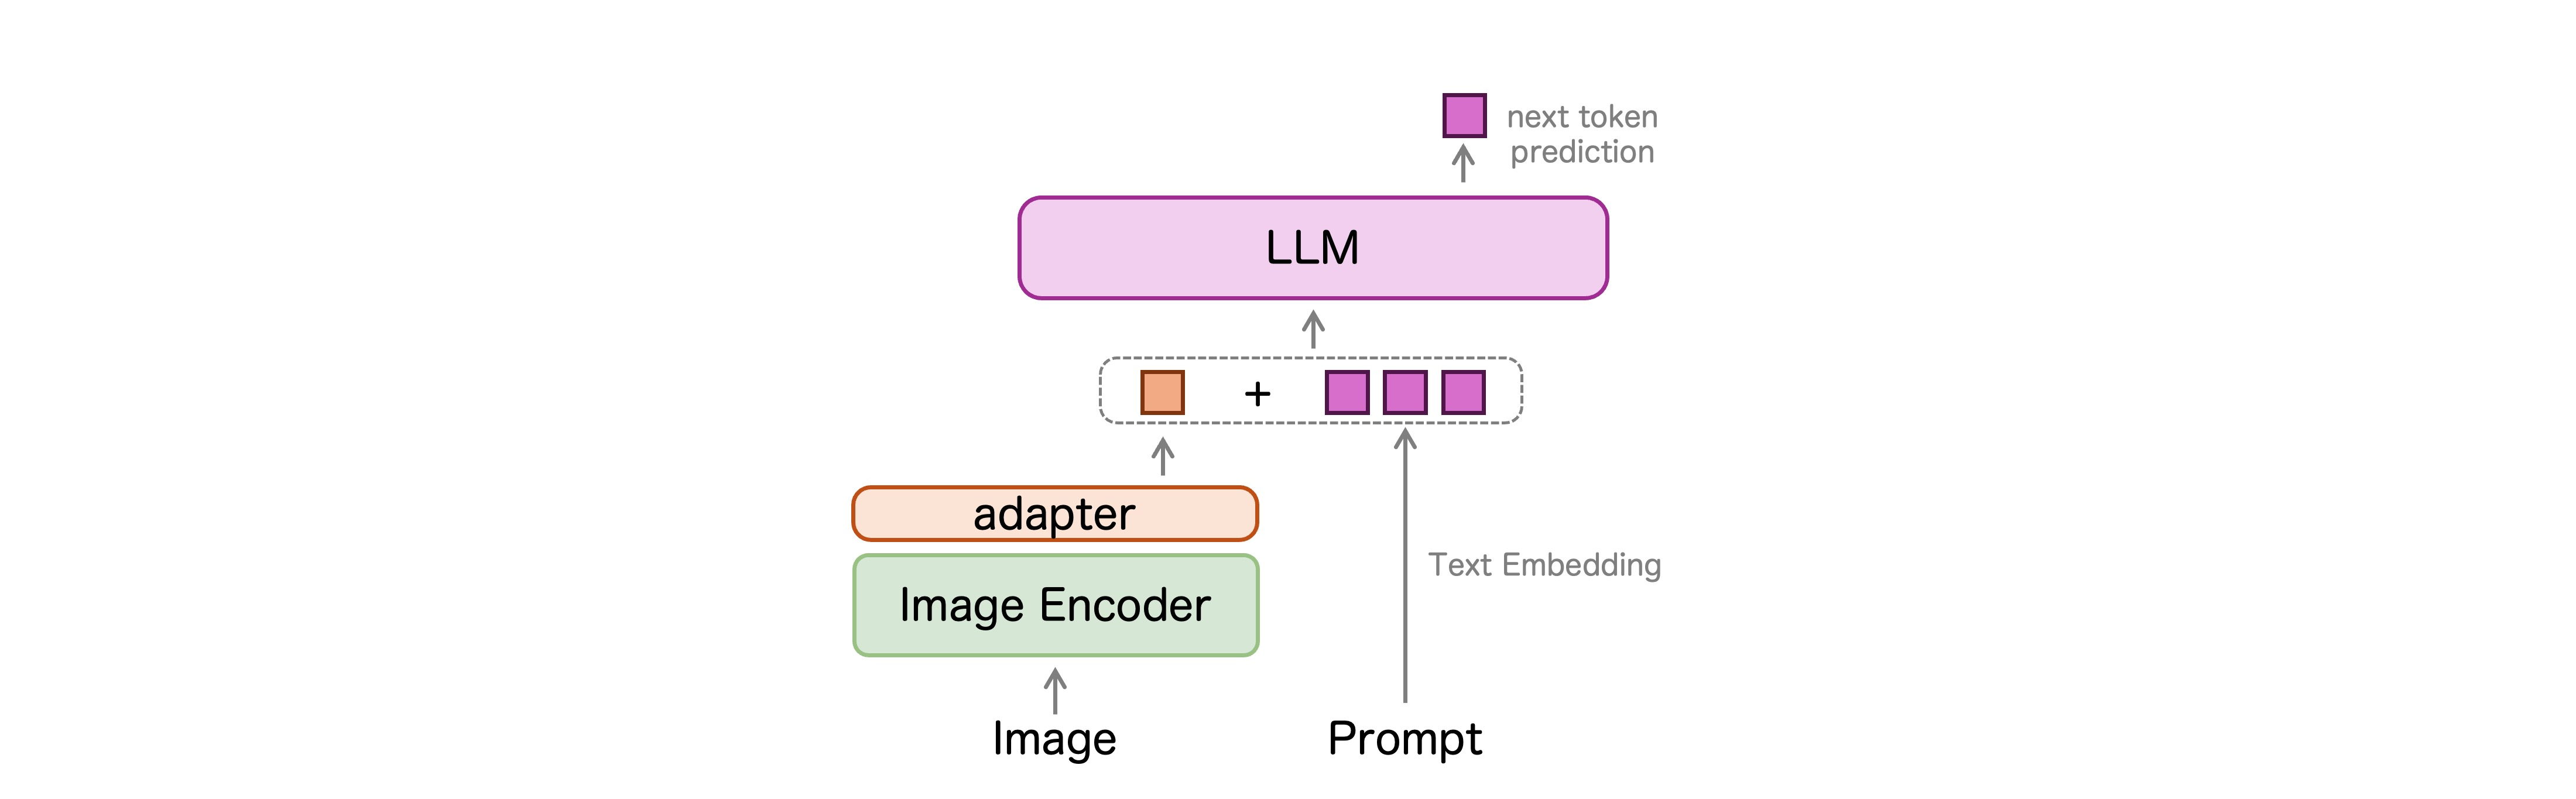

In [ ]:
class SimpleVLM(nn.Module):
    def __init__(self, gpt2_model, image_encoder, tokenizer, freeze_clip=True, freeze_gpt=False):
        super().__init__()

        self.image_encoder = image_encoder.float().eval()

        self.gpt2 = gpt2_model
        self.pad_token_id = tokenizer.pad_token_id
        self.tokenizer = tokenizer

        # adapter部分（CLIPの埋め込み次元数 -> LLMの埋め込み次元数）
        # 課題1ではここをMLPなどにして実験してみましょう
        self.adapter = nn.Linear(768, 768)

        # 凍結オプション
        if freeze_clip:
            for p in self.image_encoder.parameters():
                p.requires_grad = False
        if freeze_gpt:
            for p in self.gpt2.parameters():
                p.requires_grad = False


    def forward(self, pixel_values, input_ids, attention_mask):
        B = pixel_values.size(0)

        img_feat = self.image_encoder(pixel_values)
        img_tok  = self.adapter(img_feat)
        # [B, d] -> [B, 1, d]
        if img_tok.ndim == 2:
            img_tok = img_tok.unsqueeze(1)
        # # [B, 1, d] -> [B, 1, d]
        elif img_tok.ndim == 3:
            img_tok = img_tok
        else:
            raise ValueError(f"img_tok.ndim is {img_tok.ndim}, but it should be 2 or 3")

        text_embeds   = self.gpt2.transformer.wte(input_ids)  # [B,L,gpt2_dim]
        inputs_embeds = torch.cat([img_tok, text_embeds], dim=1)

        N_img = img_tok.size(1)
        img_mask = torch.ones(B, N_img, device=attention_mask.device, dtype=attention_mask.dtype)
        attn_mask = torch.cat([img_mask, attention_mask], dim=1)

        labels = torch.cat([torch.full((B,N_img), -100, device=input_ids.device, dtype=input_ids.dtype),
                            input_ids], dim=1)

        # transformerモデルではlabelsをforward()関数の引数に与えることで，
        # 自動的にNon-Autoregressiveに学習してlossを返します
        return self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attn_mask, labels=labels)

    def generate(self, pixel_values, prompt=""):
        self.eval()
        with torch.no_grad():
            img_tok = self.adapter(self.image_encoder(pixel_values))
            if img_tok.ndim == 2:
                img_tok = img_tok.unsqueeze(1)
            # # [B, 1, d] -> [B, 1, d]
            elif img_tok.ndim == 3:
                img_tok = img_tok
            else:
                raise ValueError(f"img_tok.ndim is {img_tok.ndim}, but it should be 2 or 3")

            if prompt:
                input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids.to(pixel_values.device)
                text_embeds = self.gpt2.transformer.wte(input_ids)
                inputs_embeds = torch.cat([img_tok, text_embeds], dim=1)
            else:
                inputs_embeds = img_tok
            gen_ids = self.gpt2.generate(
                inputs_embeds=inputs_embeds,
                max_length=40,
                do_sample=True, top_p=0.9, temperature=0.7,
                pad_token_id=self.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )
        return gen_ids

In [ ]:
# GPU確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

# 画像エンコーダは凍結、射影層 + GPT-2 を学習
vlm_model = SimpleVLM(gpt2_model, image_encoder, tokenizer=tokenizer, freeze_clip=True, freeze_gpt=False).to(device)
summary(vlm_model)

device: cuda


Layer (type:depth-idx)                                                 Param #
SimpleVLM                                                              --
├─VisionTransformer: 1-1                                               1,050,624
│    └─Conv2d: 2-1                                                     (602,112)
│    └─LayerNorm: 2-2                                                  (2,048)
│    └─Transformer: 2-3                                                --
│    │    └─Sequential: 3-1                                            (302,309,376)
│    └─LayerNorm: 2-4                                                  (2,048)
├─GPT2LMHeadModel: 1-2                                                 --
│    └─GPT2Model: 2-5                                                  --
│    │    └─Embedding: 3-2                                             38,597,376
│    │    └─Embedding: 3-3                                             786,432
│    │    └─Dropout: 3-4                                   

---
## **学習**
画像キャプションタスクでモデルを学習します．<br>
CLIPの画像エンコーダは既に一般的な画像特徴を抽出できるため，adapter部分とLLM部分を学習します．<br>

In [ ]:
# 学習の関数
def run_one_epoch(dataloader, train=True):
    vlm_model.train(train)
    total_loss, n = 0.0, 0
    pbar = tqdm(dataloader, desc="train" if train else "valid")
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = vlm_model(pixel_values, input_ids, attention_mask)
            loss = out.loss

        if train:
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            optim.zero_grad(set_to_none=True)

        total_loss += loss.item() * pixel_values.size(0)
        n += pixel_values.size(0)
        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n

In [ ]:
# 画像エンコーダは凍結、射影層 + GPT-2 を学習
optim = AdamW([p for p in vlm_model.parameters() if p.requires_grad], lr=2e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

EPOCHS = 2
best_val = float("inf")

train_loss_list = []
val_loss_list = []

for epoch in range(1, EPOCHS+1):
    train_loss = run_one_epoch(train_loader, train=True)
    val_loss   = run_one_epoch(val_loader,   train=False)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {epoch}: train {train_loss:.4f} | val {val_loss:.4f} | ppl {math.exp(val_loss):.2f}")

    # モデルの保存
    if val_loss < best_val:
        best_val = val_loss
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(vlm_model.state_dict(), "checkpoints/simple_vlm.pt")
        print(">> saved checkpoints/simple_vlm.pt")


/tmp/ipython-input-2984309035.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
train:   0%|          | 0/704 [00:00<?, ?it/s]/tmp/ipython-input-3730698802.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
valid: 100%|██████████| 79/79 [00:59<00:00,  1.33it/s, loss=0.566]


Epoch 1: train 0.7771 | val 0.5664 | ppl 1.76
>> saved checkpoints/simple_vlm.pt


valid: 100%|██████████| 79/79 [01:00<00:00,  1.31it/s, loss=0.529]


Epoch 2: train 0.5579 | val 0.5292 | ppl 1.70
>> saved checkpoints/simple_vlm.pt


### **学習結果の確認**

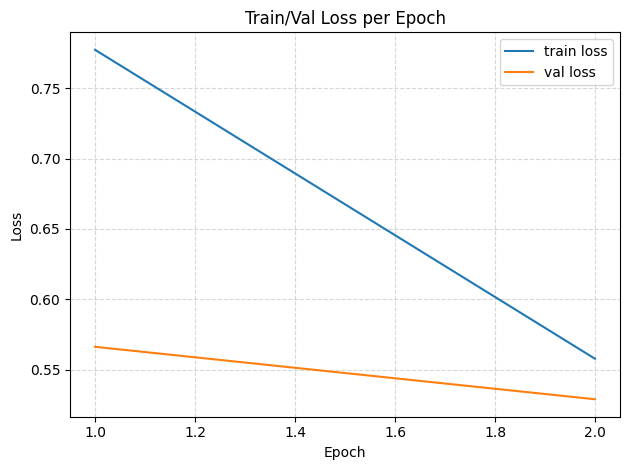

In [ ]:
epochs = list(range(1, len(train_loss_list) + 1))

# ---- Loss 曲線（train/val） ----
plt.figure()
plt.plot(epochs, train_loss_list, label="train loss")
plt.plot(epochs, val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss per Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("checkpoints/loss_curve.png", dpi=200)
plt.show()

### **（付録・課題用）学習済みのモデルの読み込み**

本ノートブックでは，データセットの定義部分でも触れたように小規模なデータセットを構築して実験を行っています．そのため学習不足が考えられるため，もともとのCOCOデータセットの学習データをそのまま使い十分に学習した重みをロードできるようにしてあります．<br>
演習時間の関係やColabの上限でモデルの学習が困難な場合や，さらなる調査などで活用してください．<br>
<br>
※ここで提供している学習済みの重みは本ノートブックを変更せず実行したときの`SimpleVLM`のモデルです．adapterの形状などを変更した場合は読み込めません．（課題用の画像エンコーダの改良版に対応したものは`SimpleVLM_alltoken.pt`です）<br>
※くわしい情報は[ここ](https://huggingface.co/Taiga10969/MPRG_DL_LectureNotebook_VLM)からご確認ください．

In [ ]:
# from huggingface_hub import hf_hub_download

# # Notebookをそのまま実行した際のモデルの学習済みモデル（COCOの学習データを全て使って学習したもの）
# filename="simple_vlm.pt"

# # 課題2のCLIPの画像エンコーダを改良して全てのトークンをLLMに渡すように変更した際のモデルの学習済みモデル（COCOの学習データを全て使って学習したもの）
# # filename="SimpleVLM_alltoken.pt"

# ckpt_path = hf_hub_download(repo_id="Taiga10969/MPRG_DL_LectureNotebook_VLM", filename=filename)
# print("Downloaded to:", ckpt_path)
# state = torch.load(ckpt_path, map_location="cpu")
# msg = vlm_model.load_state_dict(state, strict=False)
# print("msg:", msg)

---
## **画像キャプションタスクにおける定量的評価**
生成したテキストが正解ラベルとして用意されたテキストとどれだけ一致しているのかを，自然言語処理で使われる一般的な評価指標で定量的に評価します．<br>
#### `BLEU`：生成文と参照文の n-gram（一致率）を測定する評価指標

**計算方法**

1. **n-gram 精度**：参照文に含まれる n-gram の割合  

$$
p_n = \frac{\sum_{\text{ngram} \in \text{hyp}} \min\big(\text{count}_{\text{hyp}}(\text{ngram}), \ \text{count}_{\text{ref}}(\text{ngram})\big)}{\sum_{\text{ngram} \in \text{hyp}} \text{count}_{\text{hyp}}(\text{ngram})}
$$

2. **幾何平均**：複数の n-gram 精度を統合  

3. **ブリービティペナルティ（BP）**：生成文が短すぎる場合に減点  

$$
BP =
\begin{cases}
1 & (c > r) \\
e^{(1 - r/c)} & (c \le r)
\end{cases}
$$

4. **BLEU-N の最終式**  

$$
BLEU-N = BP \cdot \exp\left( \sum_{n=1}^{N} w_n \log p_n \right)
$$


**特徴**
- **長所**：計算が速く、順序を考慮した一致度評価が可能  
- **短所**：同義語や意味的類似は考慮できない  

**利用例**
- 画像キャプション評価では BLEU-4 がよく報告される  
- 他の指標（CIDEr, METEOR, SPICE）と併用されることが多い


In [ ]:
# BLEU評価用にデータセットを作成
# 評価用のmode="multi"で用意

val_ds_for_bleu = COCODataset(
    "val_small.json",
    mode="multi", # ここをmultiにしてReferencesをリストとして取得できるようにする
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=True,
)

def simple_tokenize(s: str):
    return s.strip().lower().split()

In [ ]:
# 検証用データのすべてのサンプルでテキストを生成させてBLEUを算出
refs_corpus, hyps_corpus = [], []
vlm_model.eval()
for i in tqdm(range(len(val_ds_for_bleu)), desc="BLEU: generating"):
    item = val_ds_for_bleu[i]

    # 入力画像
    pixel_values = item["pixel_values"].unsqueeze(0).to(device)

    # キャプション生成
    gen_ids = vlm_model.generate(pixel_values, prompt="A photo of")
    hyp_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # トークン化してコーパスへ追加
    hyps_corpus.append(simple_tokenize(hyp_text))
    refs_corpus.append([simple_tokenize(r) for r in item["captions"]])


bleu1 = corpus_bleu(refs_corpus, hyps_corpus, weights=(1.0, 0.0, 0.0, 0.0))
bleu2 = corpus_bleu(refs_corpus, hyps_corpus, weights=(0.5, 0.5, 0.0, 0.0))
bleu3 = corpus_bleu(refs_corpus, hyps_corpus, weights=(1/3, 1/3, 1/3, 0.0))
bleu4 = corpus_bleu(refs_corpus, hyps_corpus, weights=(0.25, 0.25, 0.25, 0.25))

print(f"BLEU-1: {bleu1:.2f}")
print(f"BLEU-2: {bleu2:.2f}")
print(f"BLEU-3: {bleu3:.2f}")
print(f"BLEU-4: {bleu4:.2f}")

BLEU: generating: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


BLEU-1: 0.45
BLEU-2: 0.26
BLEU-3: 0.14
BLEU-4: 0.08


## **画像キャプションタスクにおける定性的評価**
定性的に結果を確認します．

Image
val2017/000000015278.jpg
Ground Truth : A white plate topped with broccoli and a dumpling.
Generated : A photo of a salad on a plate.


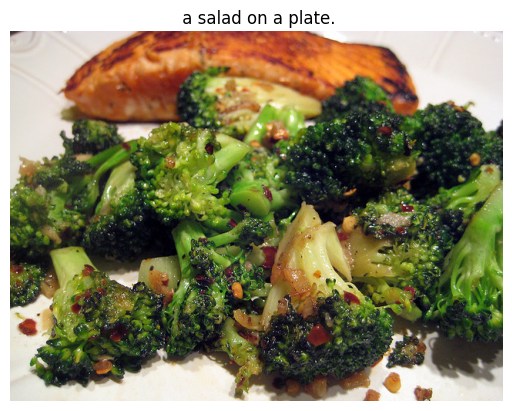

In [ ]:
vlm_model.eval()

# 可視化したい index
idx = 50

# 入力（pixel_values）は Dataset から取得
batch_item = val_ds[idx]
pixel_values = batch_item["pixel_values"].unsqueeze(0).to(device)

# データセット内の生情報（画像パス/GTキャプション）を拾う
img_file = val_ds[idx]["image_path"]
gt_caption = val_ds[idx]["caption"]
img_path = os.path.join(img_file)

# 生成
prompt="A photo of"
with torch.no_grad():
    gen_ids = vlm_model.generate(pixel_values, prompt=prompt)
gen_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

print("Image")
print(img_path)
print(f"Ground Truth : {gt_caption}")
print(f"Generated : {prompt}{gen_text}")

# 画像表示（Colab）
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(Image.open(img_path))
plt.axis("off")
plt.title(gen_text)
plt.show()

---
 ## **課題**
 1. adapter部分を単純な線形層から多層モデルに変更してみて精度を比較してみましょう
 2. CLIPの画像エンコーダの出力をクラストークンだけではなく，すべてのトークンを出力するように変更して，学習し精度を確認してみましょう．(必要リソースが大きいです．学習済みモデルを公開しています)
 3. その他の定量的評価指標を使って評価してみましょう


---
## **補足**


VisionEncoderの出力をCLSトークンだけでなく，全てのトークンを出力するようにしても，パラメータ数に変化は起きません，<br>
しかし，LLMが経験するVision的な特徴量の量に差があるため，再び学習する必要があると考えられます．<br>
- 元々CLSトークン1つの画像特徴から説明文を生成するように学習
- 全てのトークン257つ画像特徴から説明文を生成するように学習

この違いがモデルの経験値として差に現れてしまいます．<br>
どちらがより精度が良い説明文を生成することができるのでしょうか？<br>
画像特徴が1トークンだけですと，情報量が少なすぎるような気もします．（1単語と同じ情報量）<br>
しかし，画像特徴が257トークンになると，逆に情報量が多すぎる気もします．（257単語と同じ情報量）<br>
そこで，BLIP-2などもモデルでは，全ての画像特徴を数トークン（64トークン）に圧縮してLLMに渡すような仕組みになっております．<br>
※**Q-Former**: 画像特徴を圧縮するモジュール

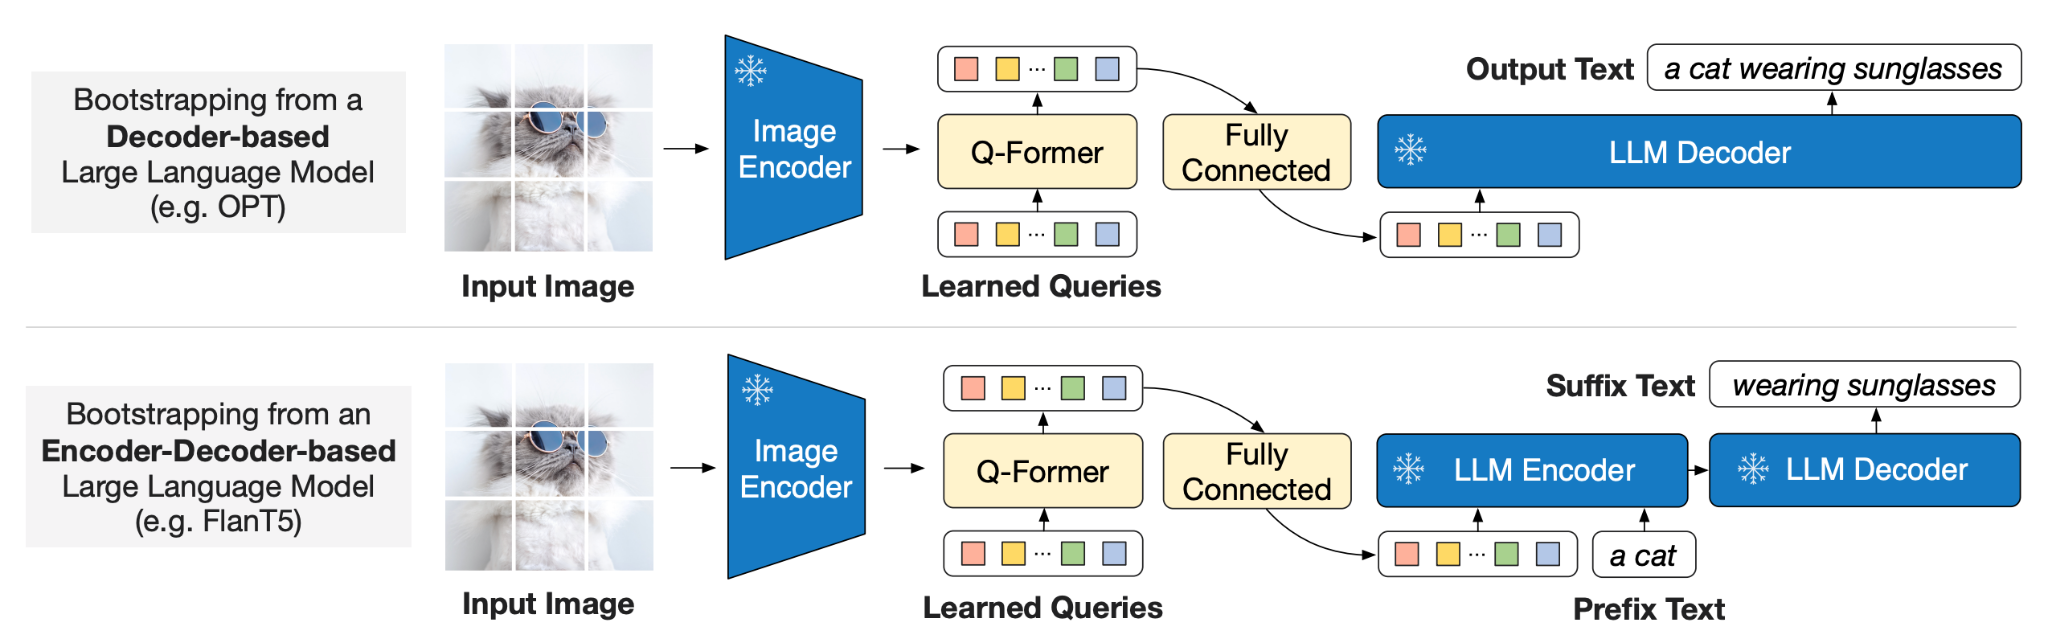